In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from spp.convex_sets import Singleton, Polyhedron, Ellipsoid
from spp.convex_functions import TwoNorm, SquaredTwoNorm
from spp.graph import GraphOfConvexSets
from spp.shortest_path import ShortestPathProblem


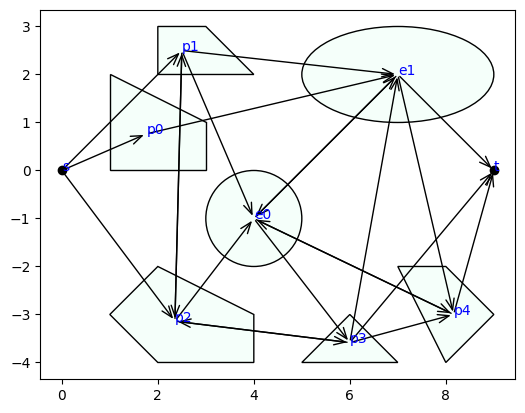

In [2]:
# convex sets
singletons = (
    Singleton((0, 0)),
    Singleton((9, 0)),
)
polyhedra = (
    Polyhedron.from_vertices(([1, 0], [1, 2], [3, 1], [3, 0])),
    Polyhedron.from_vertices(([4, 2], [3, 3], [2, 2], [2, 3])),
    Polyhedron.from_vertices(([2, -2], [1, -3], [2, -4], [4, -4], [4, -3])),
    Polyhedron.from_vertices(([5, -4], [7, -4], [6, -3])),
    Polyhedron.from_vertices(([7, -2], [8, -2], [9, -3], [8, -4])),
)
ellipsoids = (
    Ellipsoid((4, -1), ([1, 0], [0, 1])),
    Ellipsoid((7, 2), ([.25, 0], [0, 1])),
)
sets = singletons + polyhedra + ellipsoids

# label for the vertices
vertices = ['s', 't']
vertices += [f'p{i}' for i in range(len(polyhedra))]
vertices += [f'e{i}' for i in range(len(ellipsoids))]

# add convex sets to the graph
G = GraphOfConvexSets()
G.add_sets(sets, vertices)
G.set_source('s')
G.set_target('t')

# edges
H = np.hstack((np.eye(2), -np.eye(2)))
l = TwoNorm(H)
edges = {
    's': ('p0', 'p1', 'p2'),
    'p0': ('e1',),
    'p1': ('p2', 'e0', 'e1'),
    'p2': ('p1', 'p3', 'e0'),
    'p3': ('t', 'p2', 'p4', 'e1'),
    'p4': ('t', 'e0'),
    'e0': ('p3', 'p4', 'e1'),
    'e1': ('t', 'p4', 'e0')
}
for u, vs in edges.items():
    for v in vs:
        G.add_edge(u, v, l)
        
# draw convex sets and edges
plt.figure()
G.draw_sets()
G.draw_edges()
G.label_sets()
plt.show()

In [3]:
spp = ShortestPathProblem(G, relaxation=0)
spp.solve_with_dijkstra()

Source: s
Target: t
Path from s to t: ['s', 'p0', 'e1', 't']
Distance: 3


In [ ]:
import numpy as np
from pydrake.all import MathematicalProgram, MosekSolver, eq
from spp.shortest_path import ShortestPathSolution
# class FixedOrderShortestPathVariables():
#     def __init__():
#         pass
    
# class FixedOrderShortestPathProblem():
#     def __init__(self, graph, order):
#         self.graph = graph
#         self.order = order

#     def solve(self):
#         result = MosekSolver().Solve(self.prog)
#         cost = result.get_optimal_cost()
#         time = result.get_solver_details().optimizer_time
#         primal = ShortestPathVariables.from_result(result, self.vars)
#         primal.reconstruct_x(self.graph)
#         # dual = ShortestPathConstraints.from_result(result, self.constraints) if self.relaxation else None
#         dual = None

#         return ShortestPathSolution(cost, time, primal, dual)

Inputs: graph, order
order is a list of sets in the graph in the order they should be visited.

decision variables: continuous variables $x_n$, where $n$ is an integer that goes from 0 to the number of sets in order.

contraints:
vertex constraints: each $x_n \in \mathcal{X}_n$
edge constraints: each edge is valid

costs:
sum of the edge costs based on the exact vertex positions


In [9]:
print(H)
x = [0,0,3,1]
H.dot(x)

[[ 1.  0. -1. -0.]
 [ 0.  1. -0. -1.]]


array([-3., -1.])

In [ ]:

graph = G
order = ['s', 'p0', 'e1', 't']
prog = MathematicalProgram()

num_vertices = len(order)
num_edges = len(order) - 1

x = prog.NewContinuousVariables(num_vertices, G.dimension, 'x')

# Add vertex constraints
for i, v_key in enumerate(order):
    v = graph.sets[v_key]
    v.add_membership_constraint(prog, x[i])

# Add edge costs
# Domain constraints for the edges are added in add_as_cost
for i in range(num_edges):
    u = order[i]
    v = order[i + 1]
    edge_index = graph.edge_index((u, v))
    length = graph.lengths[edge_index]
    edge_vars = np.concatenate((x[i], x[i + 1]))
    length.add_as_cost(prog, edge_vars)

result = MosekSolver().Solve(prog)
cost = result.get_optimal_cost()
time = result.get_solver_details().optimizer_time
x = result.GetSolution(x)
print(f"cost = {cost}")
print(f"time = {time}")
print(f"x = {x}")
